In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
texts = [
    "안녕, 만나서 반가워.",
    "LangChain simplifies the process of building applications with large language models",
    "랭체인 한국어 튜토리얼은 LangChain의 공식 문서, cookbook 및 다양한 실용 예제를 바탕으로 하여 사용자가 LangChain을 더 쉽고 효과적으로 활용할 수 있도록 구성되어 있습니다. ",
    "LangChain은 초거대 언어모델로 애플리케이션을 구축하는 과정을 단순화합니다.",
    "Retrieval-Augmented Generation (RAG) is an effective technique for improving AI responses.",
]

In [3]:
from langchain_ollama import OllamaEmbeddings

ollama_embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    # model="chatfire/bge-m3:q8_0" # BGE-M3
)

In [4]:
# 쿼리 임베딩
embedded_query = ollama_embeddings.embed_query("LangChain 에 대해서 상세히 알려주세요.")
# 임베딩 차원 출력
if embedded_query:  # ✅ None 체크
    print(len(embedded_query))
else:
    print("❌ 임베딩 결과가 없습니다. 모델이 올바르게 로드되었는지 확인하세요.")

768


In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
from langchain_ollama import OllamaLLM

# Ollama 모델 지정
llm = OllamaLLM(model="gemma3")  # 사용할 모델 (예: "phi", "mistral", "llama3")

# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 그래프에 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

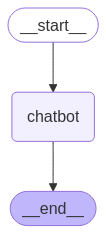

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
state = State(messages=["서울은 어느 나라 수도인가?"])
output = graph.invoke(state)
print(output)

{'messages': [HumanMessage(content='서울은 어느 나라 수도인가?', additional_kwargs={}, response_metadata={}, id='6ab739f9-2ce3-49cc-92c0-3de10f0d9d87'), HumanMessage(content='서울은 대한민국(Republic of Korea)의 수도입니다.', additional_kwargs={}, response_metadata={}, id='1076031a-edd9-4118-8c1c-5f75a72a68a9')]}


In [16]:
for update in graph.stream(state):
    print(update)

{'chatbot': {'messages': ['서울은 대한민국(Republic of Korea)의 수도입니다.']}}


In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        # 이벤트 구조: {'chatbot': {'messages': [메시지 내용]}}
        if 'chatbot' in event and 'messages' in event['chatbot']:
            messages = event['chatbot']['messages']
            if messages and len(messages) > 0:
                # 메시지가 문자열 목록인 경우
                if isinstance(messages[-1], str):
                    print("Assistant:", messages[-1])
                # 메시지가 딕셔너리인 경우 (role, content 포맷)
                elif isinstance(messages[-1], dict) and 'content' in messages[-1]:
                    print("Assistant:", messages[-1]['content'])

while True:
    try:
        user_input = input("User: ")
        if user_input in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        print("===============================")
        print(user_input)
        stream_graph_updates(user_input)
    except Exception as e:
        print(f"⚠️ Error: {e}")  # 에러 메시지 출력
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

안녕
Assistant: 안녕하세요! (Annyeonghaseyo!) 

Hello! How can I help you today? 😊 

(Translation: Hello! How can I help you today?)
서울에서 부산까지의 거리는
Assistant: 서울에서 부산까지의 거리는 대략 360~400km 정도입니다. 

*   **KTX (고속철도):** 약 2시간 30분 ~ 3시간 소요
*   **자동차:** 고속도로를 이용하면 약 4~5시간 소요
*   **버스:** 약 4시간 30분 ~ 5시간 소요

정확한 거리는 경로에 따라 조금씩 다를 수 있습니다.
알콜의 끓는 점은
Assistant: 알코올(에탄올)의 끓는점은 약 78.3℃입니다. 

다만, 알코올의 종류(분자량)에 따라 끓는점이 조금씩 달라질 수 있습니다. 예를 들어, 아이소프로판올(메탄올)은 64.7℃에서 끓습니다.
Goodbye!
